In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

print("Using TF version", tf.__version__)
print("Seeing GPUs:", tf.config.list_physical_devices('GPU'))

Using TF version 2.6.0
Seeing GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data preparation

In [3]:
def encode_ohe_matrix_2d(miRNA, gene, tensor_dim=(50, 20, 1)):  # , categories=False
    """
    fun transform input database to one hot encoding numpy array.

    parameters:
    df = Pandas df with col names "binding_sequence", "label", "mirna_binding_sequence"
    tensor_dim= 2d matrix shape

    output:
    2d dot matrix, labels as np array
    """

    # Check if input sequences have the expected length
    if (len(gene) > tensor_dim[0]) or (len(miRNA) > tensor_dim[1]):
        print(len(gene), tensor_dim[0], len(miRNA), tensor_dim[1])
        return None

    # alphabet for watson-crick interactions.
    alphabet = {"AT": 1., "TA": 1., "GC": 1., "CG": 1.}

    # initialize dot matrix with zeros
    ohe_matrix_2d = np.zeros(tensor_dim, dtype="float32")

    # compile matrix with watson-crick interactions.
    for bind_index, bind_nt in enumerate(gene):
        for mirna_index, mirna_nt in enumerate(miRNA):
            base_pairs = bind_nt + mirna_nt
            ohe_matrix_2d[bind_index, mirna_index, 0] = alphabet.get(base_pairs, 0)

    return ohe_matrix_2d


In [4]:
# Function called in "map" responsible for triggering encoding

def _encode(*row):

  mirna, gene, label = row

  encoded = encode_ohe_matrix_2d(mirna.numpy().decode("utf-8") , gene.numpy().decode("utf-8") , tensor_dim=(50, 20, 1))

  features = tf.convert_to_tensor(encoded, dtype=tf.int8)
  # label = tf.one_hot(int(label), 2, dtype=tf.int8)
  label = int(label)

  return features, label

In [5]:
# Encoding called from tf.py_function

def _py_func_encode(*x):
  return tf.py_function(_encode, x, [tf.int8, tf.int8])

def _concat_datasets(*x):
  (d1, l1), (d2, l2) = x
  return tf.concat([d1, d2], 0), tf.concat([l1, l2], 0)

### Manual data selection

Manually ensure that each batch (of a smaller size) contains the right amount of positive samples.

In [7]:
def get_dataset_manual_batches(tsv_path, batch_size=256, num_prefetch=10, negative_ratio=100):

  # Load data from csv directly
  default_dtype = [tf.string] * 3 # Load everything as strings
  dataset = tf.data.experimental.CsvDataset(
      [tsv_path],
      default_dtype,
      header=True, 
      field_delim='\t'
  )

  LABEL_P = 1
  LABEL_N = 0

  # Calc. batch size of positive samples
  batch_size_positive = batch_size // negative_ratio
  batch_size_negative = batch_size - batch_size_positive

  # Get and encode positive and negative samples separately
  positive = dataset\
          .filter(lambda *x: int(x[2]) == LABEL_P)\
          .shuffle(1000000)\
          .map(_py_func_encode, num_parallel_calls=tf.data.AUTOTUNE)\
          .batch(batch_size_positive)
  negative = dataset\
          .filter(lambda *x: int(x[2]) == LABEL_N)\
          .shuffle(1000000)\
          .map(_py_func_encode, num_parallel_calls=tf.data.AUTOTUNE)\
          .batch(batch_size_negative)
  
  """
  Combine datasets to create one where every batch contains 
  both positive and negative samples.
  """

  return tf.data.Dataset.zip((positive, negative))\
          .map(_concat_datasets)\
          .cache()\
          .prefetch(tf.data.AUTOTUNE)

### Auto data selestion

Use larger batch size to increase the probability of batch containing a positive samples. Play with class weights as well!

In [6]:
def get_dataset(tsv_path, batch_size=1024):

  # Load data from csv directly
  default_dtype = [tf.string] * 3 # Load everything as strings
  dataset = tf.data.experimental.CsvDataset(
      [tsv_path],
      default_dtype,
      header=True, 
      field_delim='\t'
  )

  # Encode dataset <-- really slow ...
  dataset = dataset.map(_py_func_encode, num_parallel_calls=tf.data.AUTOTUNE)

  # Cache encoded
  dataset = dataset.cache()

  # Shuffle dataset each time to create different batches
  dataset = dataset.shuffle(1000000, reshuffle_each_iteration=True)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

In [36]:
# base_dir = "/content/drive/MyDrive/Skola/Vysoka_skola/MUNI/Master thesis/iterative_training"
base_dir = "master_thesis/datasets"

train_dataset = get_dataset(f"{base_dir}/train_set_CLASH2013_paper.tsv")
val_dataset = get_dataset(f"{base_dir}/evaluation_set_CLASH2013_paper.tsv")

## Creating & training a model

In [7]:
from tensorflow.keras import layers

def create_model(sample_shape=(50,20,1), **kwargs):
    DATA_FORMAT = "channels_last"

    main_input = layers.Input(shape=sample_shape,
                              dtype='float32', 
                              # name='main_input'
                        )

    x = layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        data_format=DATA_FORMAT,
        # name="conv_1"
        )(main_input)    
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2),strides=None, 
                            # name='Max_1', 
                            data_format=DATA_FORMAT)(x)
    x = layers.Dropout(rate = 0.10)(x)

    x = layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        data_format=DATA_FORMAT,
        # name="conv_2"
        )(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), 
                            # name='Max_2', 
                            data_format=DATA_FORMAT)(x)
    x = layers.Dropout(rate = 0.15)(x)

    x = layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding="same",
        data_format=DATA_FORMAT,
        # name="conv_3"
        )(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), 
                            # name='Max_3', 
                            data_format=DATA_FORMAT)(x)
    x = layers.Dropout(rate = 0.20)(x)

    conv_flat = layers.Flatten(
        # name='2d_matrix'
        )(x)

    x = layers.Dense(128)(conv_flat)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate = 0.20)(x)

    x = layers.Dense(64)(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate = 0.15)(x)

    x = layers.Dense(32)(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate = 0.10)(x)

    main_output = layers.Dense(1, activation='sigmoid', 
                              #  name='main_output'
                               )(x)

    model = tf.keras.models.Model(inputs=[main_input], outputs=[main_output], **kwargs)
    
    return model

In [40]:
# preds_p = []
# preds_n = []

for i in range(1, 11):

  print("\n")
  print("-" * 30)
  print(f" Training model {i}\n")
  
  model = create_model()

  model.compile(**{
      "optimizer": tf.keras.optimizers.Adam(name="adam"),
      "loss": tf.keras.losses.BinaryCrossentropy(),
      # "loss": tf.keras.losses.CategoricalCrossentropy(),
      "metrics": [
                  # tf.keras.metrics.AUC(name="auc")
                  tf.keras.metrics.Precision(name="precision"),
                  tf.keras.metrics.Recall(name="recall")
                ]
  })

  history = model.fit(x=train_dataset, 
            validation_data=val_dataset, 
            verbose=0,
            epochs=100,
            # batch_size=batch_size,
            # steps_per_epoch=1000,
            callbacks=[
              tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0.05,
                patience=25,
                verbose=1,
                mode="min",
                baseline=None,
                restore_best_weights=True,
              ), 
              tf.keras.callbacks.ModelCheckpoint(
                f"./model_{i}.h5", 
                save_best_only=True, 
                verbose=0
              )
            ])
  
  # preds_p.append(model.predict(train_p))
  # preds_n.append(model.predict(train_n))



------------------------------
 Training model 1

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping


------------------------------
 Training model 2

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping


------------------------------
 Training model 3

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping


------------------------------
 Training model 4

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping


------------------------------
 Training model 5

Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping


------------------------------
 Training model 6

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping


------------------------------
 Training model 7

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping


------------------------------
 Training model

## Evaluating models & computing instance hardness

Evaluate all models on both 1:1 and 1:100 datasets. Predictions done on the 1:100 dataset will be used to compute instance hardness of the 1:100 negative samples (positive samples are the same!).

### Getting test data

In [9]:
def encode_and_label(row):
    return encode_ohe_matrix_2d(row['miRNA'], row['gene']), row['label']

In [94]:
base_dir = 'master_thesis/datasets'
test_df = pd.read_csv(f"{base_dir}/test_set_CLASH2013_paper.tsv", sep="\t")
test_df = test_df[['miRNA', 'gene', 'label']].apply(encode_and_label, axis=1, result_type='expand')

test_df.head()

,0,1
0,"[[[1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0...",1
1,"[[[0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1...",1
2,"[[[1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0...",1
3,"[[[1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0...",1
4,"[[[0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1...",1


In [96]:
test_df_100 = pd.read_csv(f"{base_dir}/test_set_1_100_CLASH2013_paper.tsv", sep="\t")
print("Test 100 size:", test_df_100.shape)
test_df_100 = test_df_100[['miRNA', 'gene', 'label']].apply(encode_and_label, axis=1, result_type='expand')

test_df_100.head()

,0,1
0,"[[[1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0...",1
1,"[[[0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1...",1
2,"[[[1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0...",1
3,"[[[1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0...",1
4,"[[[0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1...",1


### Evaluation

In [9]:
# Evaluate model performance on datasets
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, PrecisionRecallDisplay

Test set 1:1
precision_score		 0.8954214360041624
recall_score		 0.8605
f1_score		 0.8776134625191229
roc_auc_score		 0.9486140000000001
Test set 1:100
precision_score		 0.08748030295328622
recall_score		 0.8605
f1_score		 0.15881511558159922
roc_auc_score		 0.9502661425000001


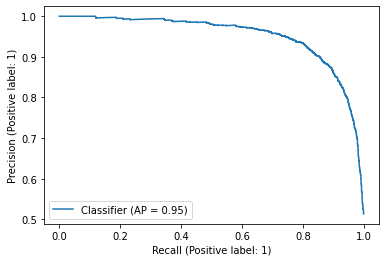

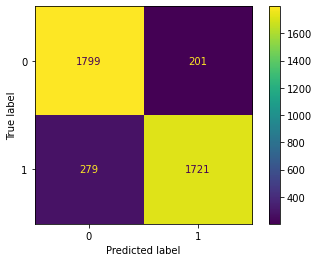

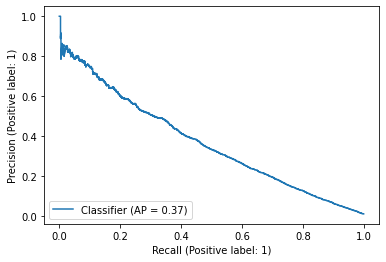

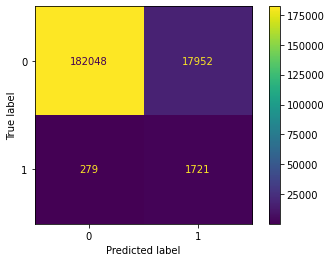

In [114]:
# Get & encode test datasets

m = tf.keras.models.load_model(
  'master_thesis/models/1_1_basic_training_shuffle/model_1.h5', custom_objects=None, compile=True, options=None
)

preds = m.predict(np.array(list(test_df[0])))

print("Test set 1:1")

PrecisionRecallDisplay.from_predictions(list(test_df[1]), preds)

ConfusionMatrixDisplay.from_predictions(list(test_df[1]), preds >= 0.5)

print("precision_score\t\t", precision_score(list(test_df[1]), preds >= 0.5))
print("recall_score\t\t", recall_score(list(test_df[1]), preds >= 0.5))
print("f1_score\t\t", f1_score(list(test_df[1]), preds >= 0.5))
print("roc_auc_score\t\t", roc_auc_score(list(test_df[1]), preds))

###################################################################################################
# 1:100

preds = m.predict(np.array(list(test_df_100[0])))

print("Test set 1:100")

PrecisionRecallDisplay.from_predictions(list(test_df_100[1]), preds)

ConfusionMatrixDisplay.from_predictions(list(test_df_100[1]), preds >= 0.5)

print("precision_score\t\t", precision_score(list(test_df_100[1]), preds >= 0.5))
print("recall_score\t\t", recall_score(list(test_df_100[1]), preds >= 0.5))
print("f1_score\t\t", f1_score(list(test_df_100[1]), preds >= 0.5))
print("roc_auc_score\t\t", roc_auc_score(list(test_df_100[1]), preds))

Computing instance hardness for 1:100 train dataset

Because this dataset is so large, it will be split into parts with 300000 samples.

In [76]:
from tqdm.notebook import tqdm

base_dir = 'master_thesis/datasets'

# Load all test data
train_df_100 = pd.read_csv(f"{base_dir}/train_set_1_100_CLASH2013_paper.tsv", sep="\t")
print("Original shape", train_df_100.shape[0], "samples")

# Shuffle data
train_df_100 = train_df_100.sample(frac=1., random_state=42, ignore_index=True)

# Get part of data
part = 5
num_samples_in_part = 300000
train_df_100 = train_df_100[num_samples_in_part * part: num_samples_in_part * (part + 1)]
print("Samples from", num_samples_in_part * part, "to", num_samples_in_part * (part + 1))

# Encode data
tqdm.pandas(desc="Encoding data")
train_df_100 = train_df_100[['miRNA', 'gene', 'label']].progress_apply(encode_and_label, axis=1, result_type='expand')

train_df_100.head()

Original shape 1554592 samples
Samples from 1500000 to 1800000


Encoding data:   0%|          | 0/54592 [00:00<?, ?it/s]

,0,1
1500000,"[[[1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0...",0
1500001,"[[[0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0...",0
1500002,"[[[0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0...",0
1500003,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
1500004,"[[[0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0...",0


In [77]:
# Evaluate model performance on datasets
from sklearn.metrics import precision_score, recall_score, f1_score

In [78]:
predictions = {}

data = np.array(list(train_df_100[0]))
labels = list(train_df_100[1])

for i in range(1, 6):

    print("\n\nModel", i, "\n")

    m = tf.keras.models.load_model(
        f'master_thesis/models/1_1_basic_training_shuffle/model_{i}.h5', custom_objects=None, compile=True, options=None
    )

    # Store predictions
    predictions[f"model_{i}"] = m.predict(data, verbose=1)

    # Show evaluation
    print("precision_score\t\t", precision_score(labels, predictions[f"model_{i}"] >= 0.5))
    print("recall_score\t\t", recall_score(labels, predictions[f"model_{i}"] >= 0.5))
    print("f1_score\t\t", f1_score(labels, predictions[f"model_{i}"] >= 0.5))




Model 1 

1706/1706 [==============================] - 8s 5ms/step
precision_score		 0.0935412026726058
recall_score		 0.9298892988929889
f1_score		 0.16998313659359193


Model 2 

1706/1706 [==============================] - 8s 4ms/step
precision_score		 0.10614406779661018
recall_score		 0.9243542435424354
f1_score		 0.19042189281641964


Model 3 

1706/1706 [==============================] - 8s 5ms/step
precision_score		 0.08851351351351351
recall_score		 0.966789667896679
f1_score		 0.16217889198390592


Model 4 

1706/1706 [==============================] - 8s 5ms/step
precision_score		 0.08986752595775152
recall_score		 0.9261992619926199
f1_score		 0.16383812010443863


Model 5 

1706/1706 [==============================] - 8s 5ms/step
precision_score		 0.11050208287656216
recall_score		 0.9298892988929889
f1_score		 0.19753086419753083


In [79]:
new_preds = {}

for k, v in predictions.items():
    new_preds[k] = v[:,0]

In [80]:
df_preds = pd.DataFrame(data=new_preds)
df_preds.tail()

,model_1,model_2,model_3,model_4,model_5
54587,0.046605,0.002804,0.002231,0.003951,0.002578
54588,0.683399,0.654191,0.739782,0.535761,0.703988
54589,0.009634,0.028980,0.219300,0.084953,0.020614
54590,0.011709,0.009043,0.127764,0.003670,0.003204
54591,0.000182,0.000319,0.000557,0.000867,0.000165


In [81]:
# Get original data
train_df_100_o = pd.read_csv(f"{base_dir}/train_set_1_100_CLASH2013_paper.tsv", sep="\t")
train_df_100_o = train_df_100_o.sample(frac=1., random_state=42, ignore_index=True)[num_samples_in_part * part: num_samples_in_part * (part + 1)]
train_df_100_o.reset_index(inplace=True)
del train_df_100_o['index']
train_df_100_o.tail()

,miRNA,gene,label
54587,AGCTGGTGTTGTGAATCAGG,TAAAATCATACACACTTTCTAGTTCTTAATATTTGTCTTTCTGAAT...,0
54588,TGAGGTAGGAGGTTGTATAG,GAAGCCATCCCCAGCCCAGCTTAAATTATAAAGATAGACAATAACT...,0
54589,TGAGGTAGTAGGTTGTATAG,ACTTGGGGCAGATTGTGGAGGGTTATATGGCCACCATGGCTGCTCA...,0
54590,TCAGAACAAATGCCGGTTCC,TGTCACAGAGGGCACCACTGAGAACTGCGTGCATAGGACCTCAAAA...,0
54591,TGGAATGTAAAGAAGTATGT,TGAAAGAGGGAGGCAGGGAGCCGGAGAGCCGGAACCGGAGTCGCAG...,0


In [82]:
df_data_preds = pd.concat([train_df_100_o, df_preds], axis=1)
df_data_preds

,miRNA,gene,label,model_1,model_2,model_3,model_4,model_5
0,TTCACAGTGGCTAAGTTCTG,ATGCTCGGCGGTGCTCAAAGGCTGGTGGCTTTTATTTCAGGGTGAA...,0,0.047723,0.018379,0.024492,0.008871,0.009191
1,CTGTGCGTGTGACAGCGGCT,ATACCTAAGAAAGTGTGTCTTCTTTAAAGCCTTGGCTTTAATCATG...,0,0.006005,0.000341,0.002746,0.002852,0.000919
2,TGAGAACTGAATTCCATAGG,TGTGCTGGCTGAGCTGGAGAAATCGGGGGCTCGACGCATTGGGGAT...,0,0.004688,0.003285,0.000441,0.012671,0.001792
3,TCACCCTGCATCCCGCACCC,CGAGGAAGACGTGGAGGGAGCCCTGGCCGGCTTGAAGACAGTGTCC...,0,0.115632,0.056937,0.018026,0.021474,0.004460
4,CTGGCCCTCTCTGCCCTTCC,AAAGATCCAAGCTGCCTGGAGGGGCTTTCACTGGCGGCAGAAATTC...,0,0.335707,0.954152,0.917284,0.423541,0.804153
...,...,...,...,...,...,...,...,...
54587,AGCTGGTGTTGTGAATCAGG,TAAAATCATACACACTTTCTAGTTCTTAATATTTGTCTTTCTGAAT...,0,0.046605,0.002804,0.002231,0.003951,0.002578
54588,TGAGGTAGGAGGTTGTATAG,GAAGCCATCCCCAGCCCAGCTTAAATTATAAAGATAGACAATAACT...,0,0.683399,0.654191,0.739782,0.535761,0.703988
54589,TGAGGTAGTAGGTTGTATAG,ACTTGGGGCAGATTGTGGAGGGTTATATGGCCACCATGGCTGCTCA...,0,0.009634,0.028980,0.219300,0.084953,0.020614
54590,TCAGAACAAATGCCGGTTCC,TGTCACAGAGGGCACCACTGAGAACTGCGTGCATAGGACCTCAAAA...,0,0.011709,0.009043,0.127764,0.003670,0.003204


In [83]:
def compute_hardness(row):

    _, _, label, *models = row

    hardness = 0

    for m in models[:5]:
        hardness += m if label == 1 else 1-m
    hardness /= len(models)

    return 1-hardness

hardness = df_data_preds.apply(compute_hardness, axis=1)
hardness

0        0.021731
1        0.002573
2        0.004575
3        0.043306
4        0.686967
           ...   
54587    0.011634
54588    0.663424
54589    0.072696
54590    0.031078
54591    0.000418
Length: 54592, dtype: float64

In [84]:
df_data_preds['hardness'] = hardness
df_data_preds.head()

,miRNA,gene,label,model_1,model_2,model_3,model_4,model_5,hardness
0,TTCACAGTGGCTAAGTTCTG,ATGCTCGGCGGTGCTCAAAGGCTGGTGGCTTTTATTTCAGGGTGAA...,0,0.047723,0.018379,0.024492,0.008871,0.009191,0.021731
1,CTGTGCGTGTGACAGCGGCT,ATACCTAAGAAAGTGTGTCTTCTTTAAAGCCTTGGCTTTAATCATG...,0,0.006005,0.000341,0.002746,0.002852,0.000919,0.002573
2,TGAGAACTGAATTCCATAGG,TGTGCTGGCTGAGCTGGAGAAATCGGGGGCTCGACGCATTGGGGAT...,0,0.004688,0.003285,0.000441,0.012671,0.001792,0.004575
3,TCACCCTGCATCCCGCACCC,CGAGGAAGACGTGGAGGGAGCCCTGGCCGGCTTGAAGACAGTGTCC...,0,0.115632,0.056937,0.018026,0.021474,0.004460,0.043306
4,CTGGCCCTCTCTGCCCTTCC,AAAGATCCAAGCTGCCTGGAGGGGCTTTCACTGGCGGCAGAAATTC...,0,0.335707,0.954152,0.917284,0.423541,0.804153,0.686967


In [85]:
df_data_preds.to_csv(f"{base_dir}/hardness_{part+1}.csv", index=False)

In [86]:
# Explore data

df_data_preds[df_data_preds['hardness'] >= 0.5].groupby('label').count()

,miRNA,gene,model_1,model_2,model_3,model_4,model_5,hardness
label,,,,,,,,
0,4017,4017,4017,4017,4017,4017,4017,4017
1,30,30,30,30,30,30,30,30


#### Merge all csv with instance hardness

In [90]:
# Load all csvs and concatenate them

df_hardness = pd.concat([
    pd.read_csv(f"{base_dir}/hardness_1.csv"), 
    pd.read_csv(f"{base_dir}/hardness_2.csv"),
    pd.read_csv(f"{base_dir}/hardness_3.csv"),
    pd.read_csv(f"{base_dir}/hardness_4.csv"),
    pd.read_csv(f"{base_dir}/hardness_5.csv"),
    pd.read_csv(f"{base_dir}/hardness_6.csv"),
    ], axis=0, ignore_index=True)

del df_hardness['model_6']
del df_hardness['model_7']

df_hardness

,miRNA,gene,label,model_1,model_2,model_3,model_4,model_5,hardness
0,ACCCTATCAATATTGTCTCT,TCTAGTGAAGATGATGAGCTGGTAGAAGAGAAGAAGCAGCAACGAA...,0,0.417197,0.115807,0.376320,0.021328,0.339230,0.467126
1,CAGTGCAATAGTATTGTCAA,CCCCTCTGCCCTGGACTTTCCCATGAGCCTCCTGGAACTGCCAGCC...,0,0.002458,0.000596,0.000301,0.000491,0.001324,0.286453
2,TAAAGTGCTTATAGTGCAGG,GACGTGCTGAAGCTGGGAGAGCAGAAACAGGCAGAGGCTGGAGAGA...,0,0.934873,0.551668,0.140858,0.502673,0.857216,0.712470
3,CTAGGTATGGTCCCAGGGAT,AGCTCATGGTCTCAGAAGGCTGGAAGGATGCAGGTTATGAGTACCT...,0,0.095796,0.135030,0.128284,0.003566,0.004440,0.338159
4,AGCTCGGTCTGAGGCCCCTC,CAGGGAAGGAGACCGTCAGGCCGCATGTAGACAATGCTGCTAAGAA...,0,0.409002,0.050827,0.307442,0.121539,0.356426,0.463605
...,...,...,...,...,...,...,...,...,...
1554587,AGCTGGTGTTGTGAATCAGG,TAAAATCATACACACTTTCTAGTTCTTAATATTTGTCTTTCTGAAT...,0,0.046605,0.002804,0.002231,0.003951,0.002578,0.011634
1554588,TGAGGTAGGAGGTTGTATAG,GAAGCCATCCCCAGCCCAGCTTAAATTATAAAGATAGACAATAACT...,0,0.683399,0.654191,0.739782,0.535761,0.703988,0.663424
1554589,TGAGGTAGTAGGTTGTATAG,ACTTGGGGCAGATTGTGGAGGGTTATATGGCCACCATGGCTGCTCA...,0,0.009634,0.028980,0.219300,0.084953,0.020614,0.072696
1554590,TCAGAACAAATGCCGGTTCC,TGTCACAGAGGGCACCACTGAGAACTGCGTGCATAGGACCTCAAAA...,0,0.011709,0.009043,0.127764,0.003670,0.003204,0.031078


In [91]:
df_hardness[df_hardness['hardness'] >= 0.5].groupby('label').count()

,miRNA,gene,model_1,model_2,model_3,model_4,model_5,hardness
label,,,,,,,,
0,132815,132815,132815,132815,132815,132815,132815,132815
1,3514,3514,3514,3514,3514,3514,3514,3514


`1/10` of negative samples and `1/5` of positive samples is considered hard!


In [92]:
df_hardness.to_csv(f"{base_dir}/train_1_100_hardness.csv", index=False)